In [1]:
from imp import reload
import sys
print(sys.version)
# import rpy2
import os
import os.path
from glob import glob
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# Use Type 1 fonts in plots.
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm

3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]


# Plotting the results of the experiments in the paper 
## Which value of $r_1$ (ratio_samples_learn) and $r_2$ (weight_samples_learn) is the best for each instance?

The learning rate $\rho$ (uBorda parameter) is **not** set manually. Instead, we use these two parameters to obtain a more interpretable setting: The value of $\rho$ is set at each iteration and depends on the set of function evaluations $F$. Parameter $\rho$ is set such that the largest $r_1$\% of the mass of the weights is concentrated in the best $r_2$\% of the solutions in $S$, i.e., 

$$
r_1 \sum_{\sigma\in S}\rho^{f(\sigma)} =  \sum_{\sigma\in S'}\rho^{f(\sigma)} \text{where} |S'| = r_2|S| \land \forall \sigma'\in S', \sigma\in S\setminus S' : f(\sigma')\geq f(\sigma)
$$


Therefore, for each instance, we plot the mean of the best fitnesses over 10 repetitions as a function of $r_1$ and $r_2$. Since we are minimizing, the lower the better. 

Overall, the values ($r_1, r_2$)=(.1,.9) have good performance, we will use this configuration for the rest of the experimental section. 

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

The following two cells perform the experiments, in particular:
- the first one run the whole combination of parameters (beware that this takes long because they are lots of executions) and we do not recomment to run here and
- the second one processes the results and generates the plots

pfsp/rec05.txt


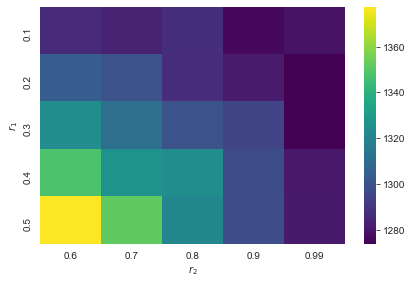

pfsp/rec13.txt


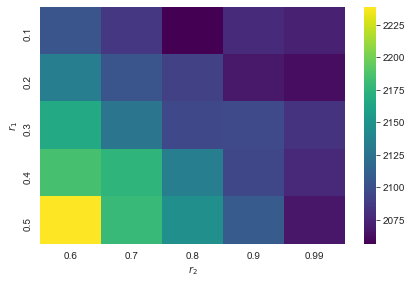

pfsp/rec19.txt


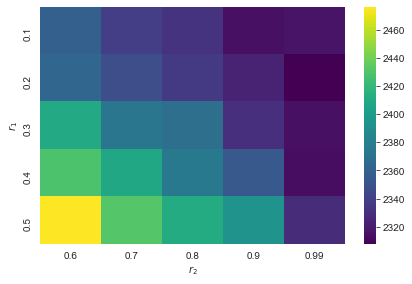

pfsp/rec31.txt


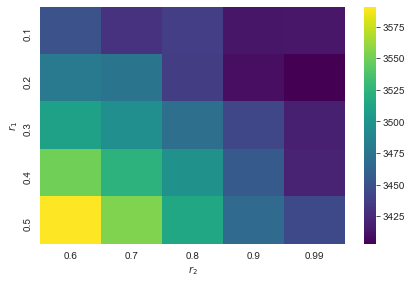

lop/RandB/N-p40-02


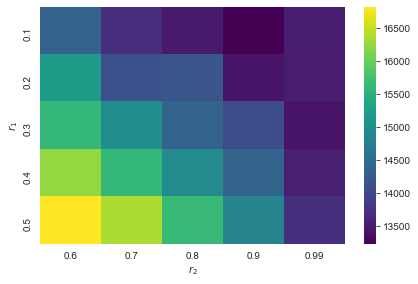

lop/RandB/N-p40-01


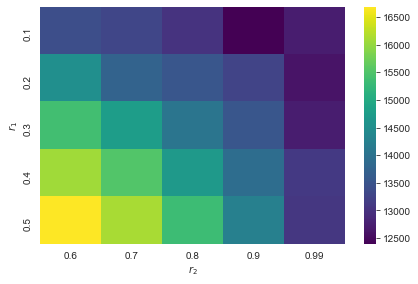

lop/IO/N-t59d11xx


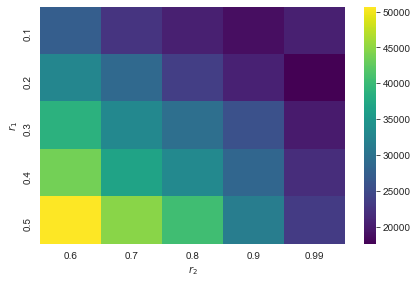

lop/IO/N-t59b11xx


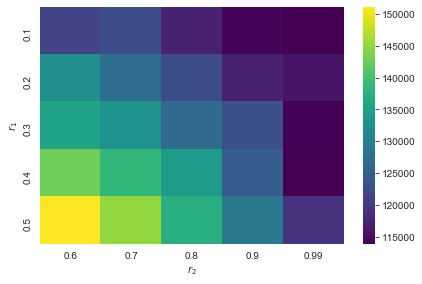

lop/SGB/N-sgb75.02


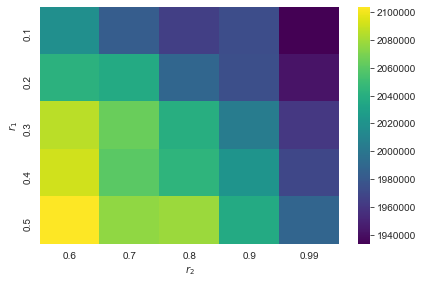

lop/SGB/N-sgb75.01


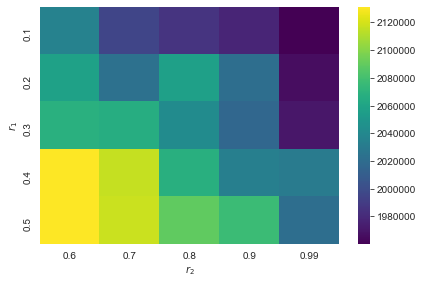

lop/RandB/N-p50-01


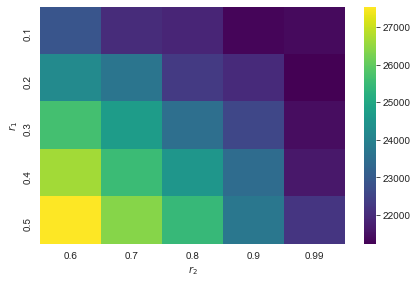

lop/RandB/N-p50-02


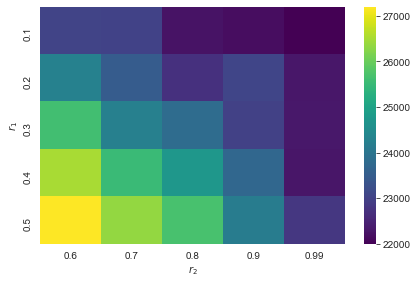

In [11]:
df = pd.read_csv('results/m400-er0/tuning.csv', sep=',')
for insta in df.instance.unique():
  print(insta)
  aux = df[df.instance==insta]
  sns.heatmap(aux.pivot_table(index='r_1', columns='r_2', values='fitness'), cmap="viridis")
  plt.tight_layout()
  plt.xlabel(r'$r_2$')
  plt.ylabel(r'$r_1$')
  plt.savefig('img/heatmap_' + insta.replace('/','_').replace('.','_') + '.pdf')
  plt.show()

In [12]:
gr = df[['instance','r_1','r_2','fitness']].groupby(['instance','r_1','r_2']).mean()
gr['rank'] = gr.groupby('instance')['fitness'].rank()
gr.groupby(['r_1','r_2']).mean().reset_index().sort_values(by='rank')

,r_1,r_2,fitness,rank
9,0.2,0.99,343315.616667,2.333333
3,0.1,0.90,346804.008333,3.166667
4,0.1,0.99,342202.508333,3.166667
14,0.3,0.99,345380.441667,3.916667
19,0.4,0.99,351333.358333,5.583333
2,0.1,0.80,347401.575000,5.666667
8,0.2,0.90,351205.791667,6.500000
24,0.5,0.99,352742.316667,7.750000
1,0.1,0.70,350381.441667,8.583333
7,0.2,0.80,356112.808333,10.250000


# Real datasets (LOP, PFSP)
In the following lines we load the results of the real dataset for CEGO and UMM, plot the results and make the comparison table

In [12]:
dfbest = pd.read_csv('best_fitness_selected.csv',sep=';')
def get_opt(instpath):
  instance_name = instpath.split('/')[-1].replace('.dat','').replace('.txt','')
  sol = dfbest[dfbest.instance_name==instance_name]#.best_known_subdiagonal.values
  if len(sol) != 1: 
    print("No opt value")
    return np.nan
  if sol.best_known_subdiagonal.isna().bool():
      return sol.best_known.iloc[0]
  else:
      return sol.best_known_subdiagonal.iloc[0]

def read_alldata(pat="./results/m400-er0/pfsp_cmax/**/*.csv.xz"):
    lis = []
    for filename in glob(pat, recursive=True):
        tmp = pd.read_csv(filename)
        tmp.instance = tmp.instance.str.replace('pfsp/','pfsp_cmax/')
        if "umm-maxmindist" in filename or "umm" not in filename:
            tmp['ini'] = "MaxMinDist"
        else:
            tmp['ini'] = "Random"
        lis.append(tmp)
    return pd.concat(lis, sort = True)
df = read_alldata()
# This is only for synthetic LOPs
#df['Uniformity'] = df.instance.str.extract(r'phi=(.+)$').astype(float)
mask = ((df.budgetMM == 1) | (df.budgetMM.isna()))
# These are the instances used in the paper
sel_insts = ['lop/IO/N-t59d11xx' ,'lop/IO/N-t59b11xx' ,'lop/SGB/N-sgb75.01' ,'lop/SGB/N-sgb75.02',
             'lop/RandB/N-p40-01','lop/RandB/N-p40-02' ,'lop/RandB/N-p50-02', 'lop/RandB/N-p50-01',
             'pfsp_cmax/rec05.txt','pfsp_cmax/rec13.txt', 'pfsp_cmax/rec19.txt',  'pfsp_cmax/rec31.txt']
df = df[(mask) & (df.instance.isin(sel_insts))]
df.loc[(df.Solver=='CEGO')&(df.eval_ranks==1),'Solver'] = 'CEGO_orig'
df.loc[(df.Solver=='CEGO')&(df.eval_ranks==0),'Solver'] = 'CEGO_inv'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==400)&(df.ini=="MaxMinDist"),'Solver'] = 'UMM_400_MaxMinDist'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==1)&(df.budget==400),'Solver'] = 'UMM_no_inv'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==400),'Solver'] = 'UMM_400'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==200),'Solver'] = 'UMM_200'
df.loc[(df.Solver=='UMM')&(df.eval_ranks==0)&(df.budget==100),'Solver'] = 'UMM_100'
df = df[df.Solver != 'UMM_no_inv'] # Skip it
#print(df.apply(lambda col: ', '.join(map(str, col.unique()))))
#print(df.groupby(['Solver', 'instance',"eval_ranks","budget","Function evaluations"])['seed'].sum())
#print(df.groupby(['Solver', 'instance',"eval_ranks","budget","Function evaluations"])['seed'].nunique())
# Checks that make sure we have the correct number of runs
assert((df.groupby(['Solver', 'instance',"eval_ranks","budget","Function evaluations"])['seed'].sum() == np.arange(1, 10 + 1).sum()).all())
assert((df.groupby(['Solver', 'instance',"eval_ranks","budget","Function evaluations"])['seed'].nunique() == 10).all())
df

,Distance,Fitness,Function evaluations,Problem,Solver,budget,budgetGA,budgetMM,eval_ranks,ini,instance,m_ini,phi_estim,phi_sample,ratio_samples_learn,rho,run_time,seed,weight_mass_learn,x
0,NaN,3909.0,1,PFSP,CEGO_inv,400,10000.0,NaN,0,MaxMinDist,pfsp_cmax/rec31.txt,10,NaN,NaN,NaN,NaN,83742.927346,8,NaN,[16 45 26 11 14 23 20 49 17 40 1 21 6 36 4 ...
1,NaN,3930.0,2,PFSP,CEGO_inv,400,10000.0,NaN,0,MaxMinDist,pfsp_cmax/rec31.txt,10,NaN,NaN,NaN,NaN,83742.927346,8,NaN,[18 31 2 6 44 42 38 47 25 43 46 48 29 27 21 ...
2,NaN,3836.0,3,PFSP,CEGO_inv,400,10000.0,NaN,0,MaxMinDist,pfsp_cmax/rec31.txt,10,NaN,NaN,NaN,NaN,83742.927346,8,NaN,[26 35 0 14 8 44 29 12 48 7 28 36 41 39 49 ...
3,NaN,3656.0,4,PFSP,CEGO_inv,400,10000.0,NaN,0,MaxMinDist,pfsp_cmax/rec31.txt,10,NaN,NaN,NaN,NaN,83742.927346,8,NaN,[27 30 37 13 5 43 9 39 12 48 15 38 20 42 44 ...
4,NaN,4059.0,5,PFSP,CEGO_inv,400,10000.0,NaN,0,MaxMinDist,pfsp_cmax/rec31.txt,10,NaN,NaN,NaN,NaN,83742.927346,8,NaN,[ 0 24 11 8 15 39 45 35 46 33 18 6 47 36 13 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,NaN,2281.0,396,PFSP,UMM_400,400,NaN,1.0,0,Random,pfsp_cmax/rec19.txt,10,0.277585,0.09375,0.1,1.989520e-13,104.937368,6,0.9,[ 0 2 12 5 8 14 6 19 18 4 10 27 22 1 15 ...
396,NaN,2289.0,397,PFSP,UMM_400,400,NaN,1.0,0,Random,pfsp_cmax/rec19.txt,10,0.274455,0.09375,0.1,1.421085e-13,104.937368,6,0.9,[ 1 2 13 5 8 11 7 19 17 4 10 28 22 0 16 ...
397,NaN,2272.0,398,PFSP,UMM_400,400,NaN,1.0,0,Random,pfsp_cmax/rec19.txt,10,0.272368,0.06250,0.1,1.136868e-13,104.937368,6,0.9,[ 1 2 12 5 8 13 7 19 18 4 11 28 22 0 15 ...
398,NaN,2285.0,399,PFSP,UMM_400,400,NaN,1.0,0,Random,pfsp_cmax/rec19.txt,10,0.269253,0.06250,0.1,9.947598e-14,104.937368,6,0.9,[ 1 2 12 5 8 13 7 19 18 4 10 28 22 0 15 ...


## Plot results
Plot the fitness along iteration of the instances in the paper, LOP and PFSP

instance:  lop/IO/N-t59d11xx
Series([], dtype: int64)
instance:  lop/IO/N-t59b11xx
Series([], dtype: int64)
instance:  lop/SGB/N-sgb75.01
Series([], dtype: int64)
instance:  lop/SGB/N-sgb75.02
Series([], dtype: int64)
instance:  lop/RandB/N-p40-01
Series([], dtype: int64)
instance:  lop/RandB/N-p40-02
Series([], dtype: int64)
instance:  lop/RandB/N-p50-02
Series([], dtype: int64)
instance:  lop/RandB/N-p50-01
Series([], dtype: int64)
instance:  pfsp_cmax/rec05.txt
Solver          eval_ranks  budget
CEGO_inv        0           400       4000
UMM_400         0           400       4000
UMM_400_MaxMin  0           400       4000
dtype: int64
optimum:  1242
Saving to img/fitness_pfsp_cmax_rec05_txt.pdf


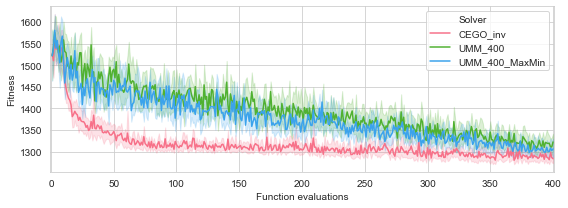

instance:  pfsp_cmax/rec13.txt
Solver          eval_ranks  budget
CEGO_inv        0           400       4000
UMM_400         0           400       4000
UMM_400_MaxMin  0           400       4000
dtype: int64
optimum:  1930
Saving to img/fitness_pfsp_cmax_rec13_txt.pdf


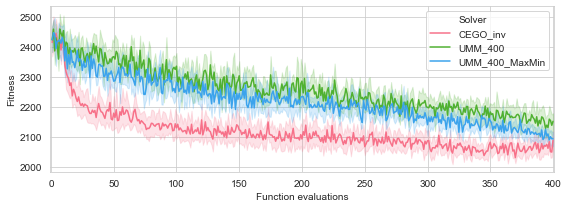

instance:  pfsp_cmax/rec19.txt
Solver          eval_ranks  budget
CEGO_inv        0           400       4000
UMM_400         0           400       4000
UMM_400_MaxMin  0           400       4000
dtype: int64
optimum:  2093
Saving to img/fitness_pfsp_cmax_rec19_txt.pdf


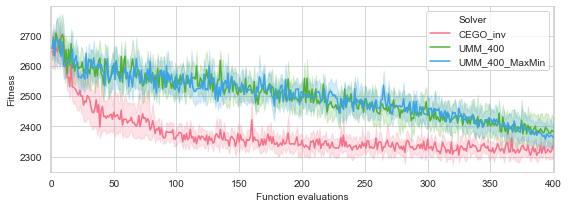

instance:  pfsp_cmax/rec31.txt
Solver          eval_ranks  budget
CEGO_inv        0           400       4000
UMM_400         0           400       4000
UMM_400_MaxMin  0           400       4000
dtype: int64
optimum:  3045
Saving to img/fitness_pfsp_cmax_rec31_txt.pdf


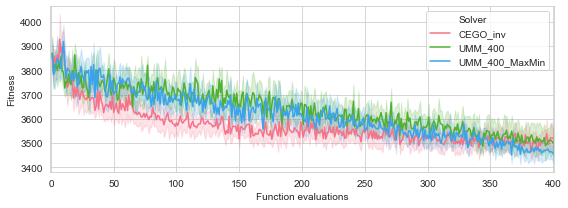

In [13]:
for inst in sel_insts:
  subdf = df[df.instance.str.contains(inst)].sort_values('Solver')
  print("instance: ", inst)
  print(subdf.groupby(['Solver', 'eval_ranks','budget' ]).size())
  if len(subdf) == 0: continue
  plt.figure(figsize=(8,3))
  val_opt = get_opt(inst)
  if val_opt is not None: 
    print("optimum: ", val_opt)
    if "pfsp" not in inst: # Skip the PFSP since the optimum is far and the plot will hide all the differences
        plt.plot([0,400],[val_opt,val_opt])
  palette = sns.color_palette("husl", subdf['Solver'].nunique())
  g = sns.lineplot(x='Function evaluations', y='Fitness', hue='Solver', data=subdf, palette=palette)
  g.set(xlim=(-1, 401))
  plt.tight_layout()
  filename = 'img/fitness_' + subdf.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
  print("Saving to " + filename)
  plt.savefig(filename)
  plt.show()

## Summary table of the results

Table with the summary of the results

In [15]:
# The maximum time per seed and evaluation is the final time. 
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max().reset_index()
dftime
# Then we calculate the mean per instance.
dftime['run_time'] =  (dftime['run_time'] / 60.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time').reset_index()
dftime.columns.name  = ''
dftime
dftime['Instance'] = [i[-1] for i in dftime.instance.str.split('/').values]
dftime['Instance'] = dftime['Instance'].str.replace('.txt','').str.replace('.dat', '')
dftime = dftime.drop('instance',axis=1)
dftime = dftime[['Problem', 'Instance', 'CEGO_inv', 'CEGO_orig', 'UMM_400', 'UMM_200', 'UMM_100']]
dftime#.sort_values(by='Instance')

print(dftime.to_latex(index=False))

\begin{tabular}{llrrrrr}
\toprule
Problem &    Instance &  CEGO\_inv &  CEGO\_orig &  UMM\_400 &  UMM\_200 &  UMM\_100 \\
\midrule
    LOP &  N-t59b11xx &   1265.98 &    1240.36 &     3.78 &     0.95 &     0.23 \\
    LOP &  N-t59d11xx &   1269.93 &    1252.89 &     3.93 &     0.97 &     0.25 \\
    LOP &    N-p40-01 &   1195.90 &    1170.81 &     3.12 &     0.85 &     0.21 \\
    LOP &    N-p40-02 &   1207.24 &    1183.09 &     3.11 &     0.83 &     0.20 \\
    LOP &    N-p50-01 &   1391.55 &    1368.55 &     4.99 &     1.28 &     0.31 \\
    LOP &    N-p50-02 &   1372.71 &    1361.96 &     4.96 &     1.28 &     0.30 \\
    LOP &  N-sgb75.01 &   1994.22 &    2004.70 &    10.88 &     2.73 &     0.72 \\
    LOP &  N-sgb75.02 &   1995.09 &    1975.41 &    10.88 &     2.76 &     0.69 \\
   PFSP &       rec05 &   1099.63 &     917.81 &     0.80 &     0.20 &     0.10 \\
   PFSP &       rec13 &   1109.51 &    1043.08 &     0.85 &     0.20 &     0.10 \\
   PFSP &       rec19 &   1090.06 &    

In [16]:
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
# df_fitness = df_fitness.groupby(['Solver','Problem','instance']).Fitness.agg(MeanFitness='mean').reset_index()
df_fitness = df_fitness.pivot_table(index=[ 'Problem', 'instance'],columns='Solver', values=['Fitness']).reset_index()

df_fitness.columns = [b if b!='' else a for (a,b)  in df_fitness.columns]
df_fitness['Instance'] = [i[-1] for i in df_fitness.instance.str.split('/').values]
df_fitness['Instance'] = df_fitness['Instance'].str.replace('.txt','').str.replace('.dat', '')
df_fitness = df_fitness.drop('instance',axis=1)
df_fitness = df_fitness[['Problem', 'Instance', 'CEGO_inv', 'CEGO_orig', 'UMM_400',       'UMM_200', 'UMM_100']]
df_fitness
print(df_fitness.to_latex(index=False))


\begin{tabular}{llrrrrr}
\toprule
Problem &    Instance &   CEGO\_inv &  CEGO\_orig &    UMM\_400 &    UMM\_200 &    UMM\_100 \\
\midrule
    LOP &  N-t59b11xx &   102408.0 &   126204.0 &   114726.5 &   120202.0 &   132039.5 \\
    LOP &  N-t59d11xx &    12692.2 &    30199.8 &    16775.4 &    23653.2 &    29884.1 \\
    LOP &    N-p40-01 &    10496.6 &    15027.7 &    12453.7 &    13361.7 &    14649.9 \\
    LOP &    N-p40-02 &    11714.7 &    15150.2 &    13191.9 &    14209.0 &    15206.2 \\
    LOP &    N-p50-01 &    18197.7 &    25666.8 &    21306.5 &    22566.0 &    24553.3 \\
    LOP &    N-p50-02 &    19090.5 &    25196.5 &    22176.5 &    23463.0 &    24050.2 \\
    LOP &  N-sgb75.01 &  1893533.2 &  2095899.6 &  1983521.2 &  2004005.6 &  2046895.1 \\
    LOP &  N-sgb75.02 &  1895801.8 &  2069286.9 &  1973083.9 &  2001244.2 &  2039356.1 \\
   PFSP &       rec05 &     1276.2 &     1318.7 &     1282.1 &     1287.0 &     1320.2 \\
   PFSP &       rec13 &     1992.9 &     2096.0 &   

In [17]:
# Keep only one CEGO and one UMM
df = df[df.Solver.isin(['CEGO_inv','UMM_400'])]
# Make sure we have the right data
mask = ((df.budget==400) & (df.eval_ranks==0)&((df.budgetMM == 1) | (df.budgetMM.isna())))
df = df[mask]
df.Solver = df.Solver.str.replace('CEGO_inv','CEGO').str.replace('UMM_400', 'UMM')

# The maximum time per seed and evaluation is the final time.
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max()
# Then we calculate the mean per instance.
dftime = dftime.groupby(['Solver','Problem','instance']).mean().reset_index()
# Convert to hours
dftime['run_time'] =  (dftime['run_time'] / 3600.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time')
dftime.rename(columns={'CEGO':'CEGO Runtime', 'UMM':'UMM Runtime'}, inplace=True)

# FEvals of CEGO
tmp = df[df.Solver == 'CEGO'].groupby(['Problem','instance','seed'])['Function evaluations'].max()
dftime['CEGO F. evaluations'] = tmp.groupby(['Problem','instance']).mean()

# Fitness
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
tmp_cego = df_fitness[df_fitness.Solver == 'CEGO'].groupby(['Problem','instance']).Fitness.agg(CEGO_Fitness_mean='mean', CEGO_Fitness_std='std').reset_index()
tmp_umm = df_fitness[df_fitness.Solver == 'UMM'].groupby(['Problem','instance']).Fitness.agg(UMM_Fitness_mean='mean', UMM_Fitness_std='std').reset_index()
df = pd.merge(tmp_cego, tmp_umm)
# Fix instance names
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df['Instance'] = df['Instance'].str.replace('.txt','').str.replace('.dat', '')
df.CEGO_Fitness_mean = df.CEGO_Fitness_mean.round(1)
df.CEGO_Fitness_std = "(" + df.CEGO_Fitness_std.round(1).astype(str) + ")"
df.UMM_Fitness_mean = df.UMM_Fitness_mean.round(1)
df.UMM_Fitness_std = "(" + df.UMM_Fitness_std.round(1).astype(str) + ")"
df = pd.merge(df, dftime, on=['Problem', 'instance'])

df = df.sort_values(['Problem', 'UMM Runtime', 'CEGO Runtime'])

for inst in df.instance:
    x, y = [ f.to_numpy() for _, f in df_fitness[df_fitness.instance == inst].groupby('Solver').Fitness]
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')])).replace('(','[').replace(')', ']')
    #df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))

# Keep only some columns
df = df[['Problem', 'Instance','CEGO_Fitness_mean','CEGO_Fitness_std','UMM_Fitness_mean','UMM_Fitness_std','Confidence interval','CEGO Runtime','UMM Runtime']]
df.reset_index(drop=True)#.to_csv('info.csv')

,Problem,Instance,CEGO_Fitness_mean,CEGO_Fitness_std,UMM_Fitness_mean,UMM_Fitness_std,Confidence interval,CEGO Runtime,UMM Runtime
0,LOP,N-p40-01,10496.6,(116.8),12453.7,(513.3),"[-2328.4, -1585.8]",19.9,0.1
1,LOP,N-p40-02,11714.7,(84.7),13191.9,(430.0),"[-1787.3, -1167.1]",20.1,0.1
2,LOP,N-t59b11xx,102408.0,(3800.2),114726.5,(5052.4),"[-16542.0, -8095.0]",21.1,0.1
3,LOP,N-t59d11xx,12692.2,(1097.9),16775.4,(1950.4),"[-5599.4, -2567.0]",21.2,0.1
4,LOP,N-p50-02,19090.5,(285.4),22176.5,(555.1),"[-3511.0, -2661.0]",22.9,0.1
5,LOP,N-p50-01,18197.7,(225.6),21306.5,(574.4),"[-3535.2, -2682.4]",23.2,0.1
6,LOP,N-sgb75.01,1893533.2,(28594.6),1983521.2,(37422.8),"[-121433.3, -58542.7]",33.2,0.2
7,LOP,N-sgb75.02,1895801.8,(82847.9),1973083.9,(64611.8),"[-147381.6, -7182.6]",33.3,0.2
8,PFSP,rec19,2264.5,(45.0),2318.5,(73.3),"[-112.0, 4.0]",18.2,0.0
9,PFSP,rec05,1276.2,(15.1),1282.1,(17.2),"[-21.2, 9.4]",18.3,0.0


In [18]:
print(df.to_latex(index=False))

\begin{tabular}{llrlrllrr}
\toprule
Problem &    Instance &  CEGO\_Fitness\_mean & CEGO\_Fitness\_std &  UMM\_Fitness\_mean & UMM\_Fitness\_std &    Confidence interval &  CEGO Runtime &  UMM Runtime \\
\midrule
    LOP &    N-p40-01 &            10496.6 &          (116.8) &           12453.7 &         (513.3) &     [-2328.4, -1585.8] &          19.9 &          0.1 \\
    LOP &    N-p40-02 &            11714.7 &           (84.7) &           13191.9 &         (430.0) &     [-1787.3, -1167.1] &          20.1 &          0.1 \\
    LOP &  N-t59b11xx &           102408.0 &         (3800.2) &          114726.5 &        (5052.4) &    [-16542.0, -8095.0] &          21.1 &          0.1 \\
    LOP &  N-t59d11xx &            12692.2 &         (1097.9) &           16775.4 &        (1950.4) &     [-5599.4, -2567.0] &          21.2 &          0.1 \\
    LOP &    N-p50-02 &            19090.5 &          (285.4) &           22176.5 &         (555.1) &     [-3511.0, -2661.0] &          22.9 &          